In [6]:
import os
import re
import nltk
import random
import json
import enchant
import pickle
import numpy as np
from sklearn import svm
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet as w,stopwords 
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
#initialising dictionary, tokenizer, stemmer and all stopwords
dictionary = enchant.Dict("en_US")
tokenizer=RegexpTokenizer('[a-zA-Z]+')
ps=PorterStemmer()
all_stopwords=stopwords.words('english')

In [8]:
def preprocess(data):       # input - sentences   output -preprocessed sentences
    dataset=[]
    for sentence in data:
        #print 'sentence : '+sentence
        temp=tokenizer.tokenize(sentence)
        #print 'tokenizer : '+ str(temp)  
        remove_stopword=[word for word in temp if word not in all_stopwords]    # removing stopwords
        #print 'stopwords : '+str(remove_stopword)
        only_english=[ps.stem(word) for word in remove_stopword if dictionary.check(word)== True]  # remove non-english words
        #print 'removed all non-english words: '+str(only_english)
        #print ' '
        if(len(only_english)>1):                  #appends only if length of list >1
            dataset.append(' '.join(only_english))
    return dataset    

In [9]:
#loading and cleaning dataset
def preprocessing(company_name):
    dataset=[]
    sentences=[]
    with open('TestReview/'+company_name+'/review.txt') as f:
        reviews=json.load(f)
    reviews=np.asarray(reviews)
    reviews=np.concatenate(reviews)        #converting it to single list from list of lists
    for review in reviews:
        review=review.lower()             #converting reviews into lowercase
        review=review.replace('. ',' ; ')                            
        sentences.extend(re.split(' and | but |; | ; |.and ',review))       #splitting criteria
    dataset=preprocess(sentences)
    with open('Dataset/'+company_name+'.txt','w') as f:
        json.dump(dataset,f)
    return dataset

In [122]:
#only for printing  
dataset=preprocessing('Samsung')

sentence :  long working hours
tokenizer : [u'long', u'working', u'hours']
stopwords : [u'long', u'working', u'hours']
removed all non-english words: [u'long', u'work', u'hour']
 
sentence : will get very little time for family
tokenizer : [u'will', u'get', u'very', u'little', u'time', u'for', u'family']
stopwords : [u'get', u'little', u'time', u'family']
removed all non-english words: [u'get', u'littl', u'time', u'famili']
 
sentence : not very process oriented
tokenizer : [u'not', u'very', u'process', u'oriented']
stopwords : [u'process', u'oriented']
removed all non-english words: [u'process', u'orient']
 
sentence : only end result oriented
tokenizer : [u'only', u'end', u'result', u'oriented']
stopwords : [u'end', u'result', u'oriented']
removed all non-english words: [u'end', u'result', u'orient']
 
sentence : they are very competitive
tokenizer : [u'they', u'are', u'very', u'competitive']
stopwords : [u'competitive']
removed all non-english words: [u'competit']
 
sentence : want 

In [155]:
#only for testing    
print dataset[:10]

[u'long work hour', u'get littl time famili', u'process orient', u'end result orient', u'want result cost', u'mostli hard', u'buyer bore', u'even need spend money like everi job', u'bore begin', u'becom habit']


In [10]:
#loading vocab for navebayes unigram
with open('../NaiveBayes/vocab_unigram') as f:
    vocab_nb_uni=json.load(f)
def extract_features_unigram_nb(document):       #features are bag of words. document is a list of words of a sentence 
    features = {}
    for word in vocab_nb_uni:
        features['contains(%s)' % word] = (word in document)
    return features

In [11]:
#loading vocab for navebayes bigram
with open('../NaiveBayes/vocab_bigram') as f:
    vocab_nb_bi=json.load(f)
def extract_features_bigram_nb(document):       #input is sentence
    features = {}
    document=[items[0]+' '+items[1] for items in nltk.bigrams(document.split())]
    for word in vocab_nb_bi:
         features['contains(%s)' % word] = (word in document)
    return features

In [12]:
#fetching aspects
aspects={}
for root, dirs, files in os.walk('../Aspects/'):
        for name in files:
            with open('../Aspects/'+name) as f:
                aspects[name]=json.load(f)          #loading pool of words for each aspects
                        
def analyse_aspect(tokens):            # analyses to which aspect a set of tokens of a sentence belong to
    count=0
    print 'Tokens : '+ str(tokens)
    aspects_in_sentence=[]
    for token in tokens:
        temp_token=ps.stem(token)
        for aspect_name in files:                               #each aspect
            for aspect in aspects[aspect_name]:                 #each word in an aspect
                temp_aspect=ps.stem(aspect)
                if(temp_token == temp_aspect):
                    aspects_in_sentence.append(aspect_name)
                    count=1
                    break
    if(count==0):
        aspects_in_sentence.append('Aspect7')
    print 'List Of Aspects : '+ str(aspects_in_sentence)
    return   aspects_in_sentence          #aspect names in which it belongs

In [186]:
#only for testing
testing=analyse_aspect(['great','learning','with','good','salary'])

Tokens : ['great', 'learning', 'with', 'good', 'salary']
List Of Aspects : ['Aspect1', 'Aspect2']


In [13]:
#aspect classification using naive bayes
def analyse_aspect_naivebayes(words):       
    aspects_in_sentence=[]
    with open('../AspectNaiveBayesClassifier/naive_bayes_unigram_model') as f:
        classifier=pickle.load(f)
    aspects_in_sentence.append(classifier.classify(extract_features_unigram_nb(words)))
    return aspects_in_sentence

In [153]:
#only for printing   naive bayes classifier for aspect
analyse_aspect_naivebayes(['great','with','hike','salari'])

['Aspect2']

In [14]:
#aspect classification using SVC                          #pending
with open('../AspectSVMClassifier/vocab_unigram') as f:
    vocab_svc_uni=json.load(f)
vectorizer = CountVectorizer(vocabulary=vocab_svc_uni,min_df=1)
    
def analyse_aspect_svc(sentence):           # inputs are words for a sentence     
    aspects_in_sentence=[]
    with open('../AspectSVMClassifier/svc_unigram_model') as f:
        classifier=pickle.load(f)
    feature_svc=vectorizer.fit_transform(sentence)    
    predicted_class=classifier.predict(feature_svc)
    #print predicted_class
    #aspects_in_sentence.append()          ######################3
    return aspects_in_sentence
#analyse_aspect_svc('a lot of gym')

In [15]:
#naiveBayes
def naiveBayes_unigram(dataset,aspect_analysis):        #first find the polarity and then its aspect
    #loading naivebayes classifier
    with open('../NaiveBayes/naive_bayes_unigram_model') as f:
        classifier=pickle.load(f)    
    aspect_polarity=Counter()
    aspect_count=Counter()
    for sentence in dataset:
        #print ' '
        #print 'sentence : '+sentence
        #print 'Polarity= '+classifier.classify(extract_features_unigram_nb(sentence.split()))
        polarity=0
        flag=0        
        dist = classifier.prob_classify(extract_features_unigram_nb(sentence.split()))
        for label in dist.samples():
            #print(" %s: %f" % (label, dist.prob(label)))
            if(polarity<dist.prob(label)):
                polarity=dist.prob(label)
                flag=label
        if(flag=='neutral'):         #Normalising
            polarity=0
        elif(flag=='pos'):
            polarity=+0.5+(polarity/2)
        elif(flag=='neg'):
            polarity=-0.5-(polarity/2)    
        elif(flag=='sli_pos'):
            polarity=polarity/2
        elif(flag=='sli_neg'):
            polarity=-(polarity/2)   
        #print 'final polarity='+ str(polarity)
        #print ' '
        if('neutral'!= flag):
            if aspect_analysis == 'lexical':
                aspects_in_sentence=analyse_aspect(sentence.split())    # returns list of aspects where polarity should be added
            elif aspect_analysis == 'naivebayes':
                aspects_in_sentence=analyse_aspect_naivebayes(sentence.split())
            for asp in aspects_in_sentence:
                aspect_polarity[asp]=aspect_polarity[asp]+polarity
                aspect_count[asp]=aspect_count[asp]+1
            #print 'aspect_polarity ='+str(aspect_polarity)
            #print ' '
            #print 'aspect_count ='+str(aspect_count)
        #print '---------------------------'
    return aspect_polarity,aspect_count

In [176]:
#for testing
aspect_polarity,aspect_count=naiveBayes_unigram(dataset[:10],'lexical')

 
sentence : long work hour
Polarity= sli_neg
 neg: 0.007710
 sli_pos: 0.116827
 sli_neg: 0.528854
 neutral: 0.302411
 pos: 0.044198
final polarity=-0.26442699595
 
Tokens : [u'long', u'work', u'hour']
List Of Aspects : ['Aspect4']
aspect_polarity =Counter({'Aspect4': -0.2644269959503445})
 
aspect_count =Counter({'Aspect4': 1})
---------------------------
 
sentence : get littl time famili
Polarity= sli_neg
 neg: 0.009013
 sli_pos: 0.120849
 sli_neg: 0.515805
 neutral: 0.353641
 pos: 0.000693
final polarity=-0.257902372943
 
Tokens : [u'get', u'littl', u'time', u'famili']
List Of Aspects : ['Aspect4']
aspect_polarity =Counter({'Aspect4': -0.5223293688937642})
 
aspect_count =Counter({'Aspect4': 2})
---------------------------
 
sentence : process orient
Polarity= neutral
 neg: 0.008148
 sli_pos: 0.275727
 sli_neg: 0.086853
 neutral: 0.504282
 pos: 0.124990
final polarity=0
 
---------------------------
 
sentence : end result orient
Polarity= neutral
 neg: 0.008062
 sli_pos: 0.234804


In [177]:
#for testing       naivebayes aspect classifier
aspect_polarity,aspect_count=naiveBayes_unigram(dataset[:10],'naivebayes')

 
sentence : long work hour
Polarity= sli_neg
 neg: 0.007710
 sli_pos: 0.116827
 sli_neg: 0.528854
 neutral: 0.302411
 pos: 0.044198
final polarity=-0.26442699595
 
aspect_polarity =Counter({'Aspect7': -0.2644269959503445})
 
aspect_count =Counter({'Aspect7': 1})
---------------------------
 
sentence : get littl time famili
Polarity= sli_neg
 neg: 0.009013
 sli_pos: 0.120849
 sli_neg: 0.515805
 neutral: 0.353641
 pos: 0.000693
final polarity=-0.257902372943
 
aspect_polarity =Counter({'Aspect4': -0.2579023729434198, 'Aspect7': -0.2644269959503445})
 
aspect_count =Counter({'Aspect7': 1, 'Aspect4': 1})
---------------------------
 
sentence : process orient
Polarity= neutral
 neg: 0.008148
 sli_pos: 0.275727
 sli_neg: 0.086853
 neutral: 0.504282
 pos: 0.124990
final polarity=0
 
---------------------------
 
sentence : end result orient
Polarity= neutral
 neg: 0.008062
 sli_pos: 0.234804
 sli_neg: 0.185296
 neutral: 0.478250
 pos: 0.093588
final polarity=0
 
---------------------------

In [278]:
#naiveBayes
def naiveBayes_bigram(dataset,aspect_analysis):        #first find the polarity and then its aspect
    #loading naivebayes classifier
    with open('../NaiveBayes/naive_bayes_bigram_model') as f:
        classifier=pickle.load(f)    
    aspect_polarity=Counter()
    aspect_count=Counter()
    for sentence in dataset:
        #print ' '
        #print 'sentence : '+sentence
        #print 'Polarity= '+classifier.classify(extract_features_bigram_nb(sentence))
        polarity=0
        flag=0        
        dist = classifier.prob_classify(extract_features_bigram_nb(sentence))
        for label in dist.samples():
            #print(" %s: %f" % (label, dist.prob(label)))
            if(polarity<dist.prob(label)):
                polarity=dist.prob(label)
                flag=label
        if(flag=='neutral'):         #Normalising
            polarity=0
        elif(flag=='pos'):
            polarity=+0.5+(polarity/2)
        elif(flag=='neg'):
            polarity=-0.5-(polarity/2)    
        elif(flag=='sli_pos'):
            polarity=polarity/2
        elif(flag=='sli_neg'):
            polarity=-(polarity/2)   
        #print 'final polarity='+ str(polarity)
        #print ' '
        if('neutral'!= flag):
            if aspect_analysis == 'lexical':
                aspects_in_sentence=analyse_aspect(sentence.split())    # returns list of aspects where polarity should be added
            elif aspect_analysis == 'naivebayes':
                aspects_in_sentence=analyse_aspect_naivebayes(sentence.split())
            for asp in aspects_in_sentence:
                aspect_polarity[asp]=aspect_polarity[asp]+polarity
                aspect_count[asp]=aspect_count[asp]+1
            #print 'aspect_polarity ='+str(aspect_polarity)
            #print ' '
            #print 'aspect_count ='+str(aspect_count)
        #print '---------------------------'
    return aspect_polarity,aspect_count

In [267]:
#for testing       naivebayes aspect classifier
aspect_polarity,aspect_count=naiveBayes_bigram(dataset[50:100],'naivebayes')

 
sentence : challeng problem new technolog
Polarity= sli_pos
 neg: 0.001006
 sli_pos: 0.700025
 sli_neg: 0.023577
 neutral: 0.134903
 pos: 0.140489
final polarity=0.350012317625
 
aspect_polarity =Counter({'Aspect1': 0.35001231762524115})
 
aspect_count =Counter({'Aspect1': 1})
---------------------------
 
sentence : develop bandwidth optim degre video stream
Polarity= neutral
 neg: 0.025212
 sli_pos: 0.171964
 sli_neg: 0.205248
 neutral: 0.346729
 pos: 0.250847
final polarity=0
 
---------------------------
 
sentence : implement video repair algorithm server stream
Polarity= neutral
 neg: 0.025212
 sli_pos: 0.171964
 sli_neg: 0.205248
 neutral: 0.346729
 pos: 0.250847
final polarity=0
 
---------------------------
 
sentence : senior help
Polarity= sli_pos
 neg: 0.034640
 sli_pos: 0.522436
 sli_neg: 0.054111
 neutral: 0.045949
 pos: 0.342865
final polarity=0.261217896638
 
aspect_polarity =Counter({'Aspect1': 0.35001231762524115, 'Aspect3': 0.26121789663825085})
 
aspect_count =Cou

In [268]:
#for testing       naivebayes aspect classifier
aspect_polarity,aspect_count=naiveBayes_bigram(dataset[50:100],'lexical')

 
sentence : challeng problem new technolog
Polarity= sli_pos
 neg: 0.001006
 sli_pos: 0.700025
 sli_neg: 0.023577
 neutral: 0.134903
 pos: 0.140489
final polarity=0.350012317625
 
aspect_polarity =Counter({'Aspect7': 0.35001231762524115})
 
aspect_count =Counter({'Aspect7': 1})
---------------------------
 
sentence : develop bandwidth optim degre video stream
Polarity= neutral
 neg: 0.025212
 sli_pos: 0.171964
 sli_neg: 0.205248
 neutral: 0.346729
 pos: 0.250847
final polarity=0
 
---------------------------
 
sentence : implement video repair algorithm server stream
Polarity= neutral
 neg: 0.025212
 sli_pos: 0.171964
 sli_neg: 0.205248
 neutral: 0.346729
 pos: 0.250847
final polarity=0
 
---------------------------
 
sentence : senior help
Polarity= sli_pos
 neg: 0.034640
 sli_pos: 0.522436
 sli_neg: 0.054111
 neutral: 0.045949
 pos: 0.342865
final polarity=0.261217896638
 
aspect_polarity =Counter({'Aspect7': 0.611230214263492})
 
aspect_count =Counter({'Aspect7': 2})
-------------

In [16]:
#unigram svc
with open('../SVM/vocab_unigram') as f:
    vocab_svc_uni=json.load(f)
#label_map={'neg':0 ,'sli_neg':1 ,'neutral':2 ,'sli_pos':3 ,'pos':4}    
def get_feature_svc(sentence):
    feature=[]
    for word in vocab_svc_uni: 
        if word in sentence.split():
            feature.append(1)
        else:
            feature.append(0)
    return feature        

In [294]:
#svm unigram
def svc_unigram(dataset,aspect_analysis):        #first find the polarity and then its aspect
    #loading naivebayes classifier
    with open('../SVM/svc_unigram_model') as f:
        classifier=pickle.load(f)    
    aspect_polarity=Counter()
    aspect_count=Counter()
    for sentence in dataset:
        #print ' '
        #print 'sentence : '+sentence
        polarity=0
        flag=0       #stores label number
        feature=get_feature_svc(sentence)
        flag=classifier.predict(feature)
        #print 'Class= '+ str(flag)        
        polarity=classifier.predict_proba(feature)[0][flag]
        #print 'Polarity = '+str(polarity)
        if(flag==2):         #Normalising
            polarity=0
        elif(flag==4):
            polarity=+0.5+(polarity/2)
        elif(flag==0):
            polarity=-0.5-(polarity/2)    
        elif(flag==3):
            polarity=polarity/2
        elif(flag==1):
            polarity=-(polarity/2)   
        #print 'final polarity='+ str(polarity)
        #print ' '
        if('neutral'!= flag):
            if aspect_analysis == 'lexical':
                aspects_in_sentence=analyse_aspect(sentence.split())    # returns list of aspects where polarity should be added
            elif aspect_analysis == 'naivebayes':
                aspects_in_sentence=analyse_aspect_naivebayes(sentence.split())
            for asp in aspects_in_sentence:
                aspect_polarity[asp]=aspect_polarity[asp]+polarity
                aspect_count[asp]=aspect_count[asp]+1
            #print 'aspect_polarity ='+str(aspect_polarity)
            #print ' '
            #print 'aspect_count ='+str(aspect_count)
        #print '---------------------------'
    return aspect_polarity,aspect_count

In [291]:
# only for displaying
aspect_polarity,aspect_count=svc_unigram(dataset[:10],'lexical')

 
sentence : long work hour
Class= [1]
Polarity = [ 0.45084411]
final polarity=[-0.22542205]
 
aspect_polarity =Counter({'Aspect4': array([-0.22542205])})
 
aspect_count =Counter({'Aspect4': 1})
---------------------------
 
sentence : get littl time famili
Class= [1]
Polarity = [ 0.75192098]
final polarity=[-0.37596049]
 
aspect_polarity =Counter({'Aspect4': array([-0.60138254])})
 
aspect_count =Counter({'Aspect4': 2})
---------------------------
 
sentence : process orient
Class= [1]
Polarity = [ 0.16727118]
final polarity=[-0.08363559]
 
aspect_polarity =Counter({'Aspect7': array([-0.08363559]), 'Aspect4': array([-0.60138254])})
 
aspect_count =Counter({'Aspect4': 2, 'Aspect7': 1})
---------------------------
 
sentence : end result orient
Class= [1]
Polarity = [ 0.32043607]
final polarity=[-0.16021804]
 
aspect_polarity =Counter({'Aspect7': array([-0.24385362]), 'Aspect4': array([-0.60138254])})
 
aspect_count =Counter({'Aspect7': 2, 'Aspect4': 2})
---------------------------
 
se

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1

Class= [1]
Polarity = [ 0.80993082]
final polarity=[-0.40496541]
 
aspect_polarity =Counter({'Aspect4': array([-0.60138254]), 'Aspect7': array([-0.93826948])})
 
aspect_count =Counter({'Aspect7': 4, 'Aspect4': 2})
---------------------------
 
sentence : buyer bore
Class= [0]
Polarity = [ 0.94650877]
final polarity=[-0.97325439]
 
aspect_polarity =Counter({'Aspect4': array([-0.60138254]), 'Aspect7': array([-1.91152386])})
 
aspect_count =Counter({'Aspect7': 5, 'Aspect4': 2})
---------------------------
 
sentence : even need spend money like everi job
Class= [4]
Polarity = [ 0.42462137]
final polarity=[ 0.71231069]
 
aspect_polarity =Counter({'Aspect4': array([-0.60138254]), 'Aspect7': array([-1.19921318])})
 
aspect_count =Counter({'Aspect7': 6, 'Aspect4': 2})
---------------------------
 
sentence : bore begin
Class= [0]
Polarity = [ 0.77953994]
final polarity=[-0.88976997]
 
aspect_polarity =Counter({'Aspect4': array([-0.60138254]), 'Aspect7': array([-2.08898314])})
 
aspect_count =

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

In [292]:
# only for displaying    naivebayes aspect classifier
aspect_polarity,aspect_count=svc_unigram(dataset[:10],'naivebayes')

 
sentence : long work hour
Class= [1]
Polarity = [ 0.45084411]
final polarity=[-0.22542205]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


aspect_polarity =Counter({'Aspect7': array([-0.22542205])})
 
aspect_count =Counter({'Aspect7': 1})
---------------------------
 
sentence : get littl time famili
Class= [1]
Polarity = [ 0.75192098]
final polarity=[-0.37596049]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect7': array([-0.22542205]), 'Aspect4': array([-0.37596049])})
 
aspect_count =Counter({'Aspect7': 1, 'Aspect4': 1})
---------------------------
 
sentence : process orient
Class= [1]
Polarity = [ 0.16727118]
final polarity=[-0.08363559]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect7': array([-0.30905764]), 'Aspect4': array([-0.37596049])})
 
aspect_count =Counter({'Aspect7': 2, 'Aspect4': 1})
---------------------------
 
sentence : end result orient
Class= [1]
Polarity = [ 0.32043607]
final polarity=[-0.16021804]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect4': array([-0.37596049]), 'Aspect7': array([-0.46927568])})
 
aspect_count =Counter({'Aspect7': 3, 'Aspect4': 1})
---------------------------
 
sentence : want result cost
Class= [1]
Polarity = [ 0.57890088]
final polarity=[-0.28945044]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect4': array([-0.37596049]), 'Aspect7': array([-0.75872612])})
 
aspect_count =Counter({'Aspect7': 4, 'Aspect4': 1})
---------------------------
 
sentence : mostli hard
Class= [1]
Polarity = [ 0.80993082]
final polarity=[-0.40496541]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect4': array([-0.37596049]), 'Aspect7': array([-1.16369153])})
 
aspect_count =Counter({'Aspect7': 5, 'Aspect4': 1})
---------------------------
 
sentence : buyer bore
Class= [0]
Polarity = [ 0.94650877]
final polarity=[-0.97325439]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect4': array([-0.37596049]), 'Aspect7': array([-2.13694591])})
 
aspect_count =Counter({'Aspect7': 6, 'Aspect4': 1})
---------------------------
 
sentence : even need spend money like everi job
Class= [4]
Polarity = [ 0.42462137]
final polarity=[ 0.71231069]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect4': array([-0.37596049]), 'Aspect7': array([-1.42463523])})
 
aspect_count =Counter({'Aspect7': 7, 'Aspect4': 1})
---------------------------
 
sentence : bore begin
Class= [0]
Polarity = [ 0.77953994]
final polarity=[-0.88976997]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect4': array([-0.37596049]), 'Aspect7': array([-2.3144052])})
 
aspect_count =Counter({'Aspect7': 8, 'Aspect4': 1})
---------------------------
 
sentence : becom habit
Class= [1]
Polarity = [ 0.40328242]
final polarity=[-0.20164121]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect4': array([-0.37596049]), 'Aspect7': array([-2.51604641])})
 
aspect_count =Counter({'Aspect7': 9, 'Aspect4': 1})
---------------------------


In [313]:
#bigram svc
with open('../NaiveBayes/vocab_bigram') as f:
    vocab_svc_bi=json.load(f)   
def get_feature_svc_bi(sentence):
    feature=[]
    document=[items[0]+' '+items[1] for items in nltk.bigrams(sentence.split())]
    for word in vocab_svc_bi: 
        if word in document:
            feature.append(1)
        else:
            feature.append(0)
    return feature        

In [ ]:
#svm bigram
def svc_bigram(dataset,aspect_analysis):        #first find the polarity and then its aspect
    #loading naivebayes classifier
    with open('../SVM/svc_bigram_model') as f:
        classifier=pickle.load(f)    
    aspect_polarity=Counter()
    aspect_count=Counter()
    for sentence in dataset:
        print ' '
        print 'sentence : '+sentence
        polarity=0
        flag=0       #stores label number
        feature=get_feature_svc_bi(sentence)
        flag=classifier.predict(feature)
        print 'Class= '+ str(flag)        
        polarity=classifier.predict_proba(feature)[0][flag]
        print 'Polarity = '+str(polarity)
        if(flag==2):         #Normalising
            polarity=0
        elif(flag==4):
            polarity=+0.5+(polarity/2)
        elif(flag==0):
            polarity=-0.5-(polarity/2)    
        elif(flag==3):
            polarity=polarity/2
        elif(flag==1):
            polarity=-(polarity/2)   
        print 'final polarity='+ str(polarity)
        print ' '
        if('neutral'!= flag):
            if aspect_analysis == 'lexical':
                aspects_in_sentence=analyse_aspect(sentence.split())    # returns list of aspects where polarity should be added
            elif aspect_analysis == 'naivebayes':
                aspects_in_sentence=analyse_aspect_naivebayes(sentence.split())
            for asp in aspects_in_sentence:
                aspect_polarity[asp]=aspect_polarity[asp]+polarity
                aspect_count[asp]=aspect_count[asp]+1
            print 'aspect_polarity ='+str(aspect_polarity)
            print ' '
            print 'aspect_count ='+str(aspect_count)
        print '---------------------------'
    return aspect_polarity,aspect_count

In [ ]:
#only for displaying
aspect_polarity,aspect_count=svc_bigram(dataset[:10],'lexical')

In [ ]:
#only for displaying
aspect_polarity,aspect_count=svc_bigram(dataset[:10],'naivebayes')

In [18]:
def plot(y_axis,x_axis,company_name):                     # plots a bar graph
    fig, ax = plt.subplots()    
    width = 0.75  # the width of the bars 
    ind = np.arange(len(y_axis))                          
    for i, v in enumerate(y_axis):                       
        ax.text(v , i, str(v), color='blue', fontweight='bold')
    ax.barh(ind, y_axis, width, color="blue")     
    ax.set_yticks(ind+width/2)                            # aligning at center 
    ax.set_yticklabels(x_axis, minor=False)
    plt.title(company_name)
    plt.xlabel('Polarity')
    plt.ylabel('Aspects')      
    plt.show()

In [19]:
# displaying the Result
def result(aspect_polarity,aspect_count,company_name):    #input - polarity for each aspec and its count
    total_polarity=0
    aspect_x_axis=[]
    aspect_y_axis=[]
    for aspect_name in files:
        if(aspect_count[aspect_name]!=0):                 
            polarity=aspect_polarity[aspect_name]/aspect_count[aspect_name]   
            total_polarity=total_polarity+polarity
        else:
            polarity=0
        aspect_x_axis.append(round(polarity,4))
        aspect_y_axis.append(str(aspects[aspect_name][0]))
    if(aspect_count['Aspect7']!=0):
        polarity=aspect_polarity['Aspect7']/aspect_count['Aspect7']
        aspect_x_axis.append(round(polarity,4))
        aspect_y_axis.append(str('General'))
    plot(aspect_x_axis,aspect_y_axis,company_name)
    total_polarity=total_polarity+polarity    
    total_polarity=total_polarity/7
    print 'Overall Polarity  '+str(total_polarity)        

In [191]:
#dataset
dataset=preprocessing('Samsung')

# NaiveBayes Unigram

Aspect Classifier = NaiveBayes


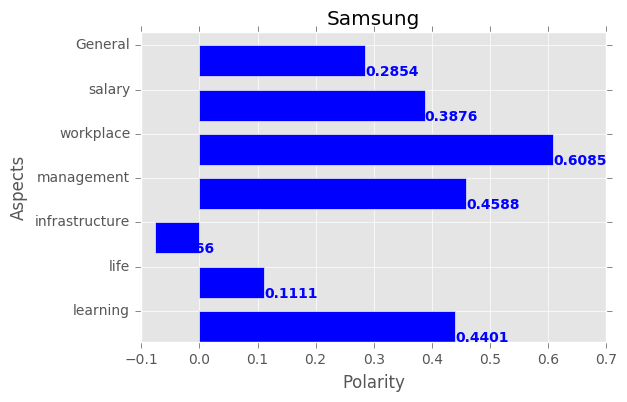

Overall Polarity  0.31641015171


In [270]:
print 'Aspect Classifier = NaiveBayes'
aspect_polarity1,aspect_count1=naiveBayes_unigram(dataset[:1000],'naivebayes')
#with open('aspect_polarity1','w') as f:
#    json.dump(aspect_polarity1,f) 
#with open('aspect_count1','w') as f:
#    json.dump(aspect_count1,f)
result(aspect_polarity1 , aspect_count1,'Samsung')

Aspect Classifier = Lexical


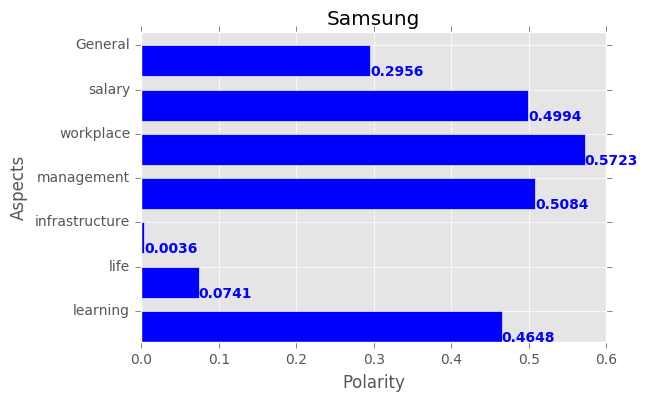

Overall Polarity  0.345459887946


In [269]:
print 'Aspect Classifier = Lexical'
aspect_polarity2,aspect_count2=naiveBayes_unigram(dataset[:1000],'lexical')
with open('aspect_polarity1','w') as f:
    json.dump(aspect_polarity1,f) 
with open('aspect_count1','w') as f:
    json.dump(aspect_count1,f)
result(aspect_polarity2 , aspect_count2,'Samsung')

# NaiveBayes Bigram

Aspect Classifier = NaiveBayes


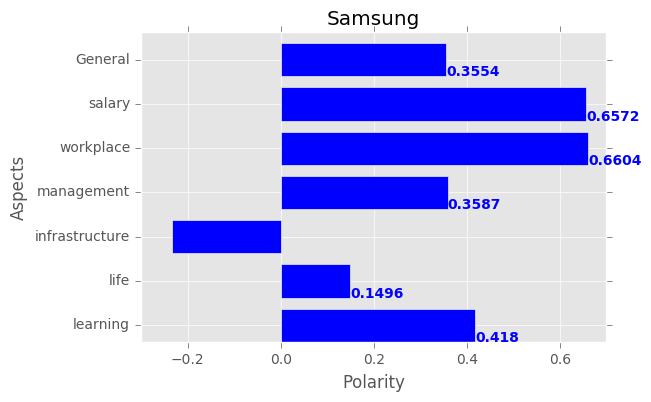

Overall Polarity  0.337872519796


In [280]:
print 'Aspect Classifier = NaiveBayes'
aspect_polarity3,aspect_count3=naiveBayes_bigram(dataset[:1000],'naivebayes')
#with open('aspect_polarity3','w') as f:
#    json.dump(aspect_polarity3,f) 
#with open('aspect_count3','w') as f:
#    json.dump(aspect_count3,f)
result(aspect_polarity3 , aspect_count3,'Samsung')

Aspect Classifier = NaiveBayes


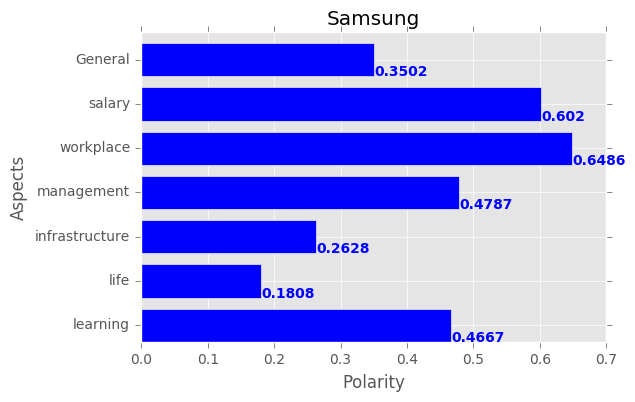

Overall Polarity  0.427125368214


In [279]:
print 'Aspect Classifier = Lexical'
aspect_polarity4,aspect_count4=naiveBayes_bigram(dataset[:1000],'lexical')
#with open('aspect_polarity4','w') as f:
#    json.dump(aspect_polarity4,f) 
#with open('aspect_count4','w') as f:
#    json.dump(aspect_count4,f)
result(aspect_polarity4 , aspect_count4,'Samsung')

# SVC Unigram

Aspect Classifier = Lexical


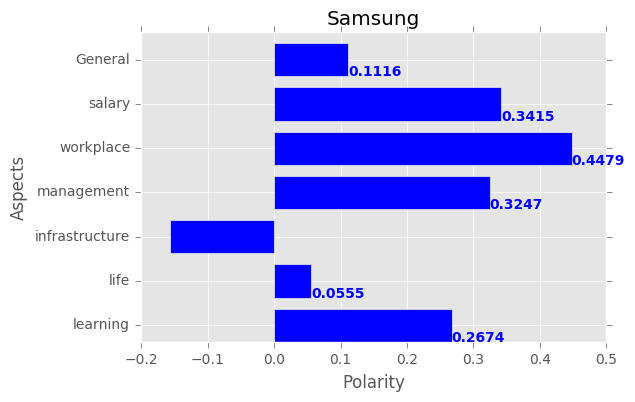

Overall Polarity  [ 0.19890909]


In [304]:
print 'Aspect Classifier = Lexical'
aspect_polarity5,aspect_count5=svc_unigram(dataset[:1000],'lexical')
#with open('aspect_polarity5','w') as f:
#    pickle.dump(aspect_polarity5,f) 
#with open('aspect_count5','w') as f:
#    pickle.dump(aspect_count5,f)
result(aspect_polarity5 , aspect_count5,'Samsung')

Aspect Classifier = NaiveBayes


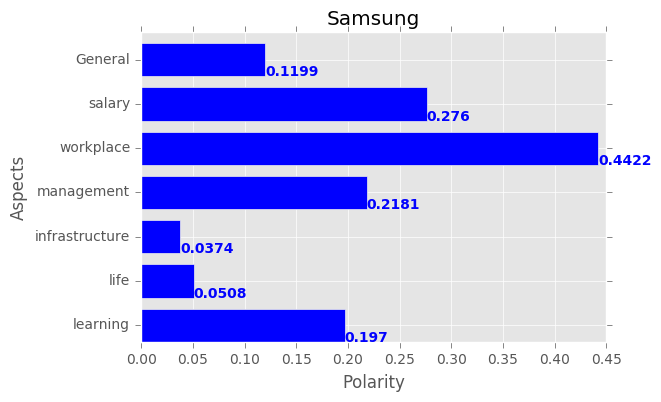

Overall Polarity  [ 0.19160693]


In [315]:
print 'Aspect Classifier = NaiveBayes'
aspect_polarity6,aspect_count6=svc_unigram(dataset[:1000],'naivebayes')
#with open('aspect_polarity6','w') as f:
#    pickle.dump(aspect_polarity6,f) 
#with open('aspect_count6','w') as f:
#    pickle.dump(aspect_count6,f)
result(aspect_polarity6 , aspect_count6,'Samsung')

# SVC Bigram

Aspect Classifier = Lexical


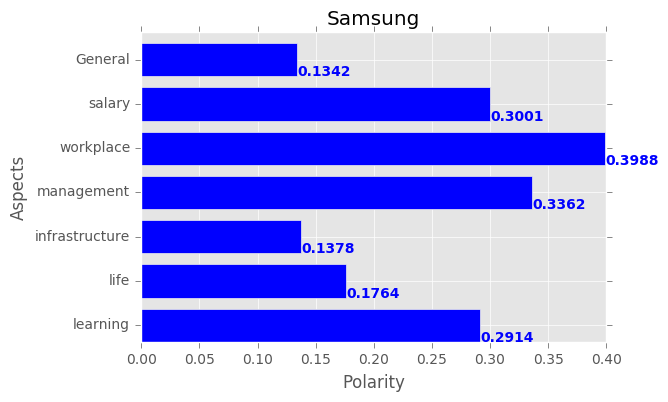

Overall Polarity  [ 0.25355098]


In [314]:
print 'Aspect Classifier = Lexical'
aspect_polarity7,aspect_count7=svc_bigram(dataset[:1000],'lexical')
#with open('aspect_polarity7','w') as f:
#    pickle.dump(aspect_polarity7,f) 
#with open('aspect_count7','w') as f:
#    pickle.dump(aspect_count7,f)
#with open('aspect_polarity7') as f:
#    aspect_polarity7=pickle.load(f)
#with open('aspect_count7') as f:
#    aspect_count7=pickle.load(f)    
result(aspect_polarity7 , aspect_count7,'Samsung')

In [ ]:
print 'Aspect Classifier = NaiveBayes'
aspect_polarity8,aspect_count8=svc_bigram(dataset[:1000],'naivebayes')
with open('aspect_polarity8','w') as f:
    pickle.dump(aspect_polarity8,f) 
with open('aspect_count8','w') as f:
    pickle.dump(aspect_count8,f)
result(aspect_polarity8 , aspect_count8,'Samsung')

Aspect Classifier = NaiveBayes


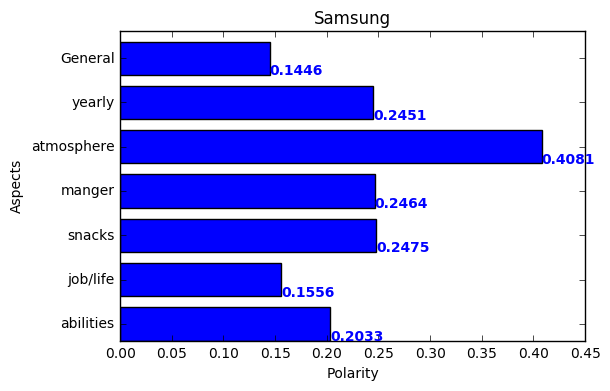

Overall Polarity  [ 0.23579964]


In [20]:
print 'Aspect Classifier = NaiveBayes'
with open('aspect_polarity8') as f:
    aspect_polarity8=pickle.load(f) 
with open('aspect_count8') as f:
    aspect_count8=pickle.load(f)
result(aspect_polarity8 , aspect_count8,'Samsung')